# **Create AwA2 dataset for Hugging Face...**

The aim is to achieve a consistent dataset format for use in machine vision and for Hugging Face.

![Keypoints description](https://raw.githubusercontent.com/prinik/AwA-Pose/main/Images/sample.png)

**Resources:**

- [AwA-Pose](https://github.com/prinik/AwA-Pose/tree/main)
- [Animals with Attributes 2](https://cvml.ista.ac.at/AwA2/)
- [A Novel Dataset for Keypoint Detection of Quadruped Animals from Images](https://arxiv.org/pdf/2108.13958)

## **Load and Imports libraries**

In [1]:
!apt install git-lfs




git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


In [2]:
print("\n",100*"#","\n")
%pip show polars
print("\n",100*"#","\n")
%pip show pandas
print("\n",100*"#","\n")
%pip show numpy
print("\n",100*"#","\n")
%pip show matplotlib
print("\n",100*"#","\n")
%pip show huggingface_hub
print("\n",100*"#","\n")
%pip show datasets
print("\n",100*"#","\n")
%pip show pyarrow
print("\n",100*"#","\n")
%pip show pillow
print("\n",100*"#","\n")
%pip show opencv-python
print("\n",100*"#","\n")


 #################################################################################################### 

Name: polars
Version: 1.21.0
Summary: Blazingly fast DataFrame library
Home-page: https://www.pola.rs/
Author: 
Author-email: Ritchie Vink <ritchie46@gmail.com>
License: 
Location: /usr/local/lib/python3.11/dist-packages
Requires: 
Required-by: cudf-polars-cu12
Note: you may need to restart the kernel to use updated packages.

 #################################################################################################### 

Name: pandas
Version: 2.2.3
Summary: Powerful data structures for data analysis, time series, and statistics
Home-page: https://pandas.pydata.org
Author: 
Author-email: The Pandas Development Team <pandas-dev@python.org>
License: BSD 3-Clause License

Copyright (c) 2008-2011, AQR Capital Management, LLC, Lambda Foundry, Inc. and PyData Development Team
All rights reserved.

Copyright (c) 2011-2023, Open source contributors.

Redistribution and use in source 

In [3]:
import zipfile
import os, sys
import base64
import io
import shutil
import json
import random
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import polars as pl
import pyarrow as pa
import cv2
import pickle

import pyarrow.parquet as pq

from PIL import Image

from kaggle_secrets import UserSecretsClient

from datasets import Dataset, DatasetDict

from huggingface_hub import (
    Repository, 
    get_full_repo_name,
    login,
    upload_folder,
    hf_hub_download,
    HfApi
)

from tqdm import tqdm

## **Support functions**

In [4]:
def save_pickle(input_save, file_path):
    try:
        with open(file_path, "wb") as outfile:
            pickle.dump(input_save, outfile)
            print(f"File: {file_path} was saved.")
    except Exception as err:
        print(f"Save file: {file_path} false!\n", err)

In [5]:
def load_pickle(file_path):
    try:
        with open(file_path, "rb") as infile:
         	record_obj = pickle.load(infile)
        return record_obj
    except Exception as err:
        print(f"Load file: {file_path} false!\n", err)

In [6]:
def load_text_file(file_path):
    try:
        with open(file_path, "r") as file:
            content = file.read()
        return content
    except Exception as err:
        print(f"Load file: {file_path} false!\n", err)

In [7]:
def save_text_file(text_save, file_path):
    try:
        with open(file_path, "a") as f:
            f.write(text_save)
            print(f"File: {file_path} was saved.")
    except Exception as err:
        print(f"Save file: {file_path} false!\n", err)

In [8]:
def load_json_file(file_path):
    try:
        with open(file_path, 'r') as file:
            data = json.load(file)
        return data
    except Exception as err:
        print(f"Load file: {file_path} false!\n", err)

In [9]:
def save_json_file(input_data, file_path):
    try:
        with open(file_path, "w") as f:
            json.dump(input_data, f, indent=4)
            print(f"File: {file_path} was saved.")
    except Exception as err:
        print(f"Save file: {file_path} false!\n", err)
    

In [10]:
def list_files_dir(path_dir):
    files_dist = {}
    
    file_names = os.listdir(path_dir)
    
    for file_name in file_names:
        name = file_name.split('.')[0]
        path = os.path.join(path_dir, file_name)
        files_dist[name] = path
    
    return files_dist

In [11]:
def list_dir_in_dir(path_dir):
    directories = [name for name in os.listdir(path_dir) if os.path.isdir(os.path.join(path_dir, name))]
    return directories

In [12]:
def img_to_base64(path_img):
    s_obj = io.BytesIO()
    s_obj.seek(0)
    img = Image.open(path_img)
    img.save(s_obj, format=img.format)  # We save the original format (JPEG, PNG, atd.)
    base64_str = base64.b64encode(s_obj.getvalue()).decode('utf-8')
    return base64_str

In [13]:
def base64_to_img(base64_str):
    img_bytes = base64.b64decode(base64_str)
    img_buffer = io.BytesIO(img_bytes)
    img = Image.open(img_buffer)
    
    return img

In [14]:
def get_image_dimensions(image_path):
    try:
        with Image.open(image_path) as img:
            return img.size
    except FileNotFoundError:
        print(f"Error: File not found at path: {image_path}")
        return None
    except IOError:
        print(f"Error: The file at path {image_path} cannot be identified as an image.")
        return None

In [15]:
def plot_graph(input_data):
    """
    Plots a graph from dictionary data including null values.
    """
    # Correct way to create a DataFrame from a dictionary
    df = pd.DataFrame(list(input_data.items()), columns=['Category', 'Count'])

    # Sort the DataFrame so that zero values are at the end
    df_sorted = df.sort_values(by='Count', ascending=False)
    
    # Adjust the chart size for better clarity
    plt.figure(figsize=(12, 16))
    
    # Create a horizontal bar chart
    plt.barh(df_sorted['Category'], df_sorted['Count'], color='skyblue')

    # Setting labels and names
    plt.xlabel('Count', fontsize=12)
    plt.ylabel('Category', fontsize=12)
    plt.title('Number of values in each category', fontsize=14)
    plt.gca().invert_yaxis()  # Rotate the Y axis for clarity

    # Adding values to bars
    for index, value in enumerate(df_sorted['Count']):
        plt.text(value, index, str(value), ha='left', va='center')
        
    plt.tight_layout()
    plt.show()

## **Load data**

#### ***Path of directories***

In [16]:
path_pose_data = os.path.join('/kaggle','input','awa2-dataset','AwA2','pose','Annotations')
path_images = os.path.join('/kaggle','input','awa2-dataset','AwA2','data','JPEGImages')
path_license_image = os.path.join('/kaggle','input','awa2-dataset','AwA2','data','licenses')

#### ***Names of directories of files***

#### *Images:*

In [17]:
list_dir_images = list_dir_in_dir(path_images)
list_dir_images_sort = sorted(list_dir_images)
print(f"Number of images of directories is {len(list_dir_images_sort)}")
print('\n', list_dir_images_sort)

Number of images of directories is 50

 ['antelope', 'bat', 'beaver', 'blue+whale', 'bobcat', 'buffalo', 'chihuahua', 'chimpanzee', 'collie', 'cow', 'dalmatian', 'deer', 'dolphin', 'elephant', 'fox', 'german+shepherd', 'giant+panda', 'giraffe', 'gorilla', 'grizzly+bear', 'hamster', 'hippopotamus', 'horse', 'humpback+whale', 'killer+whale', 'leopard', 'lion', 'mole', 'moose', 'mouse', 'otter', 'ox', 'persian+cat', 'pig', 'polar+bear', 'rabbit', 'raccoon', 'rat', 'rhinoceros', 'seal', 'sheep', 'siamese+cat', 'skunk', 'spider+monkey', 'squirrel', 'tiger', 'walrus', 'weasel', 'wolf', 'zebra']


#### *licence of images:*

In [18]:
list_dir_licenses = list_dir_in_dir(path_license_image)
list_dir_licenses_sort = sorted(list_dir_licenses)
print(f"Number of licenses of directories is {len(list_dir_licenses_sort)}")
print('\n', list_dir_licenses_sort)

Number of licenses of directories is 50

 ['antelope', 'bat', 'beaver', 'blue+whale', 'bobcat', 'buffalo', 'chihuahua', 'chimpanzee', 'collie', 'cow', 'dalmatian', 'deer', 'dolphin', 'elephant', 'fox', 'german+shepherd', 'giant+panda', 'giraffe', 'gorilla', 'grizzly+bear', 'hamster', 'hippopotamus', 'horse', 'humpback+whale', 'killer+whale', 'leopard', 'lion', 'mole', 'moose', 'mouse', 'otter', 'ox', 'persian+cat', 'pig', 'polar+bear', 'rabbit', 'raccoon', 'rat', 'rhinoceros', 'seal', 'sheep', 'siamese+cat', 'skunk', 'spider+monkey', 'squirrel', 'tiger', 'walrus', 'weasel', 'wolf', 'zebra']


#### *pose data:*

In [19]:
list_dir_pose_data = list_dir_in_dir(path_pose_data)
list_dir_pose_data_sort = sorted(list_dir_pose_data)
print(f"Number of licenses of directories is {len(list_dir_pose_data_sort)}")
print('\n', list_dir_pose_data_sort)

Number of licenses of directories is 37

 ['antelope', 'bobcat', 'buffalo', 'chihuahua', 'collie', 'cow', 'dalmatian', 'deer', 'elephant', 'fox', 'german+shepherd', 'giant+panda', 'giraffe', 'grizzly+bear', 'hippopotamus', 'horse', 'leopard', 'lion', 'moose', 'otter', 'ox', 'persian+cat', 'pig', 'polar+bear', 'rabbit', 'raccoon', 'rat', 'rhinoceros', 'sample', 'sheep', 'siamese+cat', 'skunk', 'squirrel', 'tiger', 'weasel', 'wolf', 'zebra']


> Note: At first glance, it is clear that the image dataset and their positions are not identical.

#### *Check class*

In [20]:
print(list_dir_licenses_sort==list_dir_images_sort)
print(list_dir_licenses_sort==list_dir_pose_data_sort and list_dir_pose_data_sort==list_dir_images_sort)

True
False


## **Create dataframe of pose annotation**

In [21]:
total_dataset_list = []

In [22]:
%%time
for directory in tqdm(list_dir_pose_data_sort):
    path = os.path.join(path_pose_data, directory)
    data_list = list_files_dir(path)
    for data_path in data_list:
        path_input = os.path.join(path_pose_data, directory, data_path + '.pickle')
        data = load_pickle(path_input)
        data_input = data['a1']
        data_input['name_file'] = data_path
        data_input['name_class'] = directory
        total_dataset_list.append(data_input)
       
        

100%|██████████| 37/37 [01:32<00:00,  2.50s/it]

CPU times: user 3.59 s, sys: 3.05 s, total: 6.64 s
Wall time: 1min 32s


In [23]:
#total_dataset_list

In [24]:
df_keypoints_data = pd.DataFrame(total_dataset_list)
df_polars_keypoints_data = pl.from_pandas(df_keypoints_data)

In [25]:
df_polars_keypoints_data.head(10)

right_eye,right_earbase,right_earend,right_antler_base,right_antler_end,left_antler_base,left_antler_end,left_earbase,left_earend,left_eye,nose,upper_jaw,lower_jaw,mouth_end_right,throat_base,neck_base,neck_end,back_base,back_middle,back_end,tail_base,body_middle_right,bbox,mouth_end_left,throat_end,tail_end,front_left_thai,front_left_knee,front_left_paw,front_right_thai,front_right_paw,front_right_knee,back_left_knee,back_left_paw,back_left_thai,back_right_thai,back_right_paw,back_right_knee,belly_bottom,body_middle_left,name_file,name_class,left_antlerbase,left_antlerend,right_antlerend,right_antlerbase,neckbase,neckend,backbase,backmiddle,backend,tailend,bellybottom,back_right_pi,tail_e,left_eara,right_earE,right_earea,left_ear_base,left_ear_end,right_ear_end,right_ear_base,tail_ea,wither,throat,left_ey,throat_be,tail_be,back_left_ta
list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],str,str,list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64]
"[359.571429, 658.428571]","[285.857143, 634.428571]","[96.142857, 520.142857]","[363.0, 563.0]","[67.0, 92.714286]","[453.857143, 539.571429]","[296.714286, 82.428571]","[407.0, 539.0]","[423.0, 467.571429]","[508.142857, 635.571429]","[544.142857, 796.714286]","[550.428571, 821.285714]","[541.857143, 840.714286]","[488.142857, 831.0]","[453.285714, 865.285714]","[290.428571, 696.142857]","[265.857143, 869.285714]","[253.285714, 871.0]","[107.571429, 824.714286]","[32.714286, 785.857143]","[15.0, 783.571429]","[21.285714, 965.857143]","[0.0, 73.0, … 1022.428571]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","""antelope_10060""","""antelope""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"[799.454545, 213.727273]","[769.909091, 195.545455]","[790.363636, 158.727273]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[794.0, 183.727273]","[809.0, 156.454545]","[-1.0, -1.0]","[856.727273, 260.090909]","[854.0, 271.909091]","[843.090909, 274.636364]","[831.272727, 266.454545]","[764.0, 257.818182]","[744.0, 211.0]","[658.545455, 269.181818]","[643.090909, 270.090909]","[501.727273, 255.545455]","[340.363636, 290.090909]","[329.909091, 299.636364]","[509.909091, 319.636364]","[225.363636, 150.090909, … 614.636364]","[-1.0, -1.0]","[669.909091, 340.545455]","[335.363636, 373.727273]","[618.545455, 398.272727]","[658.545455, 431.0]","[662.636364, 541.0]","[594.0, 368.272727]","[567.636364, 586.454545]","[569.909091, 471.454545]","[384.909091, 471.0]","[446.727273, 575.090909]","[409.909091, 405.090909]","[389.454545, 365.090909]","[243.545455, 595.545455]","[298.090909, 460.090909]","[496.272727, 399.636364]","[-1.0, -1.0]","""antelope_10014""","""antelope""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"[-1.0, -1.0]","[447.181818, 291.909091]","[433.545455, 252.363636]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[464.909091, 317.363636]","[463.545455, 278.272727]","[427.636364, 335.545455]","[375.818182, 356.0]","[371.727273, 363.727273]","[376.272727, 376.0]","[-1.0, -1.0]","[446.727273, 395.090909]","[491.727273, 333.2727

In [26]:
columns_keypoints_df = df_polars_keypoints_data.columns
columns_keypoints_df

['right_eye',
 'right_earbase',
 'right_earend',
 'right_antler_base',
 'right_antler_end',
 'left_antler_base',
 'left_antler_end',
 'left_earbase',
 'left_earend',
 'left_eye',
 'nose',
 'upper_jaw',
 'lower_jaw',
 'mouth_end_right',
 'throat_base',
 'neck_base',
 'neck_end',
 'back_base',
 'back_middle',
 'back_end',
 'tail_base',
 'body_middle_right',
 'bbox',
 'mouth_end_left',
 'throat_end',
 'tail_end',
 'front_left_thai',
 'front_left_knee',
 'front_left_paw',
 'front_right_thai',
 'front_right_paw',
 'front_right_knee',
 'back_left_knee',
 'back_left_paw',
 'back_left_thai',
 'back_right_thai',
 'back_right_paw',
 'back_right_knee',
 'belly_bottom',
 'body_middle_left',
 'name_file',
 'name_class',
 'left_antlerbase',
 'left_antlerend',
 'right_antlerend',
 'right_antlerbase',
 'neckbase',
 'neckend',
 'backbase',
 'backmiddle',
 'backend',
 'tailend',
 'bellybottom',
 'back_right_pi',
 'tail_e',
 'left_eara',
 'right_earE',
 'right_earea',
 'left_ear_base',
 'left_ear_end',
 

## **Create dataframe of image**

In [27]:
total_image_list = []

In [28]:
%%time
for directory in tqdm(list_dir_images_sort):
    path_img = os.path.join(path_images, directory)
    path_license = os.path.join(path_license_image, directory)
    data_list_img = list_files_dir(path_img)
    data_list_license = list_files_dir(path_license)
    for i, data_path in enumerate(data_list_img):
        data_dict = {}
        
        path_input_img = os.path.join(path_img, data_path + '.jpg')
        path_input_license = os.path.join(path_license, data_path + '.txt')
        
        image_base64 = img_to_base64(path_input_img)
        image_width, image_height = get_image_dimensions(path_input_img)
        text_license = load_text_file(path_input_license)
        
        data_dict['name_file'] = data_path
        data_dict['name_class'] = directory
        data_dict['image_base64s'] = image_base64
        data_dict['image_width'] = image_width
        data_dict['image_height'] = image_height
        data_dict['image_license'] = text_license
        total_image_list.append(data_dict)

100%|██████████| 50/50 [24:28<00:00, 29.37s/it]

CPU times: user 8min 55s, sys: 50.5 s, total: 9min 45s
Wall time: 24min 28s


In [29]:
#total_image_list

In [30]:
df_images_data = pd.DataFrame(total_image_list)
df_polars_images_data = pl.from_pandas(df_images_data)

In [31]:
df_polars_images_data.head(10)

name_file,name_class,image_base64s,image_width,image_height,image_license
str,str,str,i64,i64,str
"""antelope_10702""","""antelope""","""/9j/4AAQSkZJRgABAQAAAQABAAD/2w…",1024,683,"""+-----------------------------…"
"""antelope_10558""","""antelope""","""/9j/4AAQSkZJRgABAQAAAQABAAD/2w…",1024,1024,"""+-----------------------------…"
"""antelope_10111""","""antelope""","""/9j/4AAQSkZJRgABAQAAAQABAAD/2w…",1024,662,"""+-----------------------------…"
"""antelope_10192""","""antelope""","""/9j/4AAQSkZJRgABAQAAAQABAAD/2w…",924,502,"""+-----------------------------…"
"""antelope_10625""","""antelope""","""/9j/4AAQSkZJRgABAQAAAQABAAD/2w…",1024,683,"""+-----------------------------…"
"""antelope_10216""","""antelope""","""/9j/4AAQSkZJRgABAQAAAQABAAD/2w…",1024,549,"""+-----------------------------…"
"""antelope_11022""","""antelope""","""/9j/4AAQSkZJRgABAQAAAQABAAD/2w…",1024,768,"""+-----------------------------…"
"""antelope_10831""","""antelope""","""/9j/4AAQSkZJRgABAQAAAQABAAD/2w…",1024,766,"""+-----------------------------…"
"""antelope_10186""","""antelope""","""/9j/4AAQSkZJRgABAQAAAQABAAD/2w…",1024,754,"""+-----------------------------…"


In [32]:
columns_images_df = df_polars_images_data.columns
columns_images_df

['name_file',
 'name_class',
 'image_base64s',
 'image_width',
 'image_height',
 'image_license']

## **Unifying data from tables**

### **Show table data**

In [33]:
print('Number of rows of keypoints dataframe:', df_polars_keypoints_data.shape[0])
print('Number of rows of image dataframe:', df_polars_images_data.shape[0])

print('Number of columns of keypoints dataframe:', df_polars_keypoints_data.shape[1])
print('Number of columns of image dataframe:', df_polars_images_data.shape[1])

Number of rows of keypoints dataframe: 10596
Number of rows of image dataframe: 37322
Number of columns of keypoints dataframe: 69
Number of columns of image dataframe: 6


In [34]:
df_polars_keypoints_data.head(2)

right_eye,right_earbase,right_earend,right_antler_base,right_antler_end,left_antler_base,left_antler_end,left_earbase,left_earend,left_eye,nose,upper_jaw,lower_jaw,mouth_end_right,throat_base,neck_base,neck_end,back_base,back_middle,back_end,tail_base,body_middle_right,bbox,mouth_end_left,throat_end,tail_end,front_left_thai,front_left_knee,front_left_paw,front_right_thai,front_right_paw,front_right_knee,back_left_knee,back_left_paw,back_left_thai,back_right_thai,back_right_paw,back_right_knee,belly_bottom,body_middle_left,name_file,name_class,left_antlerbase,left_antlerend,right_antlerend,right_antlerbase,neckbase,neckend,backbase,backmiddle,backend,tailend,bellybottom,back_right_pi,tail_e,left_eara,right_earE,right_earea,left_ear_base,left_ear_end,right_ear_end,right_ear_base,tail_ea,wither,throat,left_ey,throat_be,tail_be,back_left_ta
list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],str,str,list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64]
"[359.571429, 658.428571]","[285.857143, 634.428571]","[96.142857, 520.142857]","[363.0, 563.0]","[67.0, 92.714286]","[453.857143, 539.571429]","[296.714286, 82.428571]","[407.0, 539.0]","[423.0, 467.571429]","[508.142857, 635.571429]","[544.142857, 796.714286]","[550.428571, 821.285714]","[541.857143, 840.714286]","[488.142857, 831.0]","[453.285714, 865.285714]","[290.428571, 696.142857]","[265.857143, 869.285714]","[253.285714, 871.0]","[107.571429, 824.714286]","[32.714286, 785.857143]","[15.0, 783.571429]","[21.285714, 965.857143]","[0.0, 73.0, … 1022.428571]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","""antelope_10060""","""antelope""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"[799.454545, 213.727273]","[769.909091, 195.545455]","[790.363636, 158.727273]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[794.0, 183.727273]","[809.0, 156.454545]","[-1.0, -1.0]","[856.727273, 260.090909]","[854.0, 271.909091]","[843.090909, 274.636364]","[831.272727, 266.454545]","[764.0, 257.818182]","[744.0, 211.0]","[658.545455, 269.181818]","[643.090909, 270.090909]","[501.727273, 255.545455]","[340.363636, 290.090909]","[329.909091, 299.636364]","[509.909091, 319.636364]","[225.363636, 150.090909, … 614.636364]","[-1.0, -1.0]","[669.909091, 340.545455]","[335.363636, 373.727273]","[618.545455, 398.272727]","[658.545455, 431.0]","[662.636364, 541.0]","[594.0, 368.272727]","[567.636364, 586.454545]","[569.909091, 471.454545]","[384.909091, 471.0]","[446.727273, 575.090909]","[409.909091, 405.090909]","[389.454545, 365.090909]","[243.545455, 595.545455]","[298.090909, 460.090909]","[496.272727, 399.636364]","[-1.0, -1.0]","""antelope_10014""","""antelope""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null


In [35]:
df_polars_images_data.head(2)

name_file,name_class,image_base64s,image_width,image_height,image_license
str,str,str,i64,i64,str
"""antelope_10702""","""antelope""","""/9j/4AAQSkZJRgABAQAAAQABAAD/2w…",1024,683,"""+-----------------------------…"
"""antelope_10558""","""antelope""","""/9j/4AAQSkZJRgABAQAAAQABAAD/2w…",1024,1024,"""+-----------------------------…"


### **Clean image data**

In [36]:
df_polars_images_data_clean = df_polars_images_data.drop("name_class")

In [37]:
df_polars_images_data_clean.head(2)

name_file,image_base64s,image_width,image_height,image_license
str,str,i64,i64,str
"""antelope_10702""","""/9j/4AAQSkZJRgABAQAAAQABAAD/2w…",1024,683,"""+-----------------------------…"
"""antelope_10558""","""/9j/4AAQSkZJRgABAQAAAQABAAD/2w…",1024,1024,"""+-----------------------------…"


### **Join tables**

In [38]:
df_animals_keypoints = df_polars_keypoints_data.join(df_polars_images_data_clean, on="name_file", how="inner")

In [39]:
df_animals_keypoints.head(5)

right_eye,right_earbase,right_earend,right_antler_base,right_antler_end,left_antler_base,left_antler_end,left_earbase,left_earend,left_eye,nose,upper_jaw,lower_jaw,mouth_end_right,throat_base,neck_base,neck_end,back_base,back_middle,back_end,tail_base,body_middle_right,bbox,mouth_end_left,throat_end,tail_end,front_left_thai,front_left_knee,front_left_paw,front_right_thai,front_right_paw,front_right_knee,back_left_knee,back_left_paw,back_left_thai,back_right_thai,back_right_paw,back_right_knee,belly_bottom,body_middle_left,name_file,name_class,left_antlerbase,left_antlerend,right_antlerend,right_antlerbase,neckbase,neckend,backbase,backmiddle,backend,tailend,bellybottom,back_right_pi,tail_e,left_eara,right_earE,right_earea,left_ear_base,left_ear_end,right_ear_end,right_ear_base,tail_ea,wither,throat,left_ey,throat_be,tail_be,back_left_ta,image_base64s,image_width,image_height,image_license
list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],str,str,list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],str,i64,i64,str
"[613.545455, 199.909091]","[574.454545, 199.454545]","[596.272727, 171.272727]","[605.363636, 171.727273]","[491.727273, 74.0]","[613.090909, 169.454545]","[519.909091, 78.090909]","[-1.0, -1.0]","[629.909091, 163.545455]","[-1.0, -1.0]","[675.363636, 230.818182]","[674.0, 240.818182]","[669.909091, 248.545455]","[654.454545, 241.727273]","[609.909091, 253.545455]","[562.181818, 210.818182]","[533.090909, 260.818182]","[525.363636, 263.545455]","[409.0, 259.909091]","[248.545455, 278.545455]","[241.727273, 287.181818]","[410.363636, 329.909091]","[238.090909, 68.090909, … 561.727273]","[-1.0, -1.0]","[566.272727, 326.727273]","[269.454545, 356.727273]","[460.818182, 394.0]","[452.181818, 449.454545]","[440.818182, 548.545455]","[491.272727, 377.181818]","[505.818182, 551.727273]","[494.454545, 455.818182]","[306.272727, 448.090909]","[333.090909, 544.454545]","[328.090909, 399.0]","[322.636364, 353.090909]","[303.545455, 554.0]","[279.909091, 440.363636]","[401.727273, 389.454545]","[-1.0, -1.0]","""antelope_10005""","""antelope""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""/9j/4AAQSkZJRgABAQAAAQABAAD//g…",1024,684,"""+-----------------------------…"
"[684.909091, 251.636364]","[608.090909, 216.636364]","[473.545455, 83.909091]","[687.181818, 182.090909]","[564.909091, 11.181818]","[713.545455, 163.454545]","[634.0, 184.363636]","[693.090909, 135.272727]","[766.272727, 44.818182]","[-1.0, -1.0]","[817.636364, 328.909091]","[799.0, 353.909091]","[790.818182, 381.181818]","[763.545455, 348.0]","[666.272727, 401.181818]","[570.818182, 245.272727]","[482.181818, 385.272727]","[462.181818, 371.181818]","[171.727273, 278.454545]","[-1.0, -1.0]","[-1.0, -1.0]","[136.727273, 448.0]","[1.0, 1.181818, … 682.0]","[-1.0, -1.0]","[503.090909, 574.818182]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[300.363636, 628.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","""antelope_10507""","""antelope""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""/9j/4AAQSkZJRgABAQAAAQABAAD/2w…",1024,683,"""+-----------------------------…"
"[-1.0, -1.0]","[409.389671, 347.887324]","[403.755

In [40]:
print('Number of rows of keypoints dataframe:', df_animals_keypoints.shape[0])
print('Number of columns of keypoints dataframe:', df_animals_keypoints.shape[1])

Number of rows of keypoints dataframe: 10596
Number of columns of keypoints dataframe: 73


### **Add `id` column**

In [41]:
df_animals_keypoints_all = df_animals_keypoints.with_row_index(name='id', offset=0)

In [42]:
df_animals_keypoints_all.head(5)

id,right_eye,right_earbase,right_earend,right_antler_base,right_antler_end,left_antler_base,left_antler_end,left_earbase,left_earend,left_eye,nose,upper_jaw,lower_jaw,mouth_end_right,throat_base,neck_base,neck_end,back_base,back_middle,back_end,tail_base,body_middle_right,bbox,mouth_end_left,throat_end,tail_end,front_left_thai,front_left_knee,front_left_paw,front_right_thai,front_right_paw,front_right_knee,back_left_knee,back_left_paw,back_left_thai,back_right_thai,back_right_paw,back_right_knee,belly_bottom,body_middle_left,name_file,name_class,left_antlerbase,left_antlerend,right_antlerend,right_antlerbase,neckbase,neckend,backbase,backmiddle,backend,tailend,bellybottom,back_right_pi,tail_e,left_eara,right_earE,right_earea,left_ear_base,left_ear_end,right_ear_end,right_ear_base,tail_ea,wither,throat,left_ey,throat_be,tail_be,back_left_ta,image_base64s,image_width,image_height,image_license
u32,list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],str,str,list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],str,i64,i64,str
0,"[613.545455, 199.909091]","[574.454545, 199.454545]","[596.272727, 171.272727]","[605.363636, 171.727273]","[491.727273, 74.0]","[613.090909, 169.454545]","[519.909091, 78.090909]","[-1.0, -1.0]","[629.909091, 163.545455]","[-1.0, -1.0]","[675.363636, 230.818182]","[674.0, 240.818182]","[669.909091, 248.545455]","[654.454545, 241.727273]","[609.909091, 253.545455]","[562.181818, 210.818182]","[533.090909, 260.818182]","[525.363636, 263.545455]","[409.0, 259.909091]","[248.545455, 278.545455]","[241.727273, 287.181818]","[410.363636, 329.909091]","[238.090909, 68.090909, … 561.727273]","[-1.0, -1.0]","[566.272727, 326.727273]","[269.454545, 356.727273]","[460.818182, 394.0]","[452.181818, 449.454545]","[440.818182, 548.545455]","[491.272727, 377.181818]","[505.818182, 551.727273]","[494.454545, 455.818182]","[306.272727, 448.090909]","[333.090909, 544.454545]","[328.090909, 399.0]","[322.636364, 353.090909]","[303.545455, 554.0]","[279.909091, 440.363636]","[401.727273, 389.454545]","[-1.0, -1.0]","""antelope_10005""","""antelope""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""/9j/4AAQSkZJRgABAQAAAQABAAD//g…",1024,684,"""+-----------------------------…"
1,"[684.909091, 251.636364]","[608.090909, 216.636364]","[473.545455, 83.909091]","[687.181818, 182.090909]","[564.909091, 11.181818]","[713.545455, 163.454545]","[634.0, 184.363636]","[693.090909, 135.272727]","[766.272727, 44.818182]","[-1.0, -1.0]","[817.636364, 328.909091]","[799.0, 353.909091]","[790.818182, 381.181818]","[763.545455, 348.0]","[666.272727, 401.181818]","[570.818182, 245.272727]","[482.181818, 385.272727]","[462.181818, 371.181818]","[171.727273, 278.454545]","[-1.0, -1.0]","[-1.0, -1.0]","[136.727273, 448.0]","[1.0, 1.181818, … 682.0]","[-1.0, -1.0]","[503.090909, 574.818182]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[300.363636, 628.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","""antelope_10507""","""antelope""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""/9j/4AAQSkZJRgABAQAAAQABAAD/2w…",1024,683,"""+-----------------------------…"
2,"[-1.0, -1.0]","[409.389671, 347.88732

## **Review data**

### **Finding null values in a dataset**

Finding null values in a dataset, which is the number of unannotated quantities depending on the class.

In [43]:
columns_names_df = df_animals_keypoints_all.columns
print(columns_names_df)

['id', 'right_eye', 'right_earbase', 'right_earend', 'right_antler_base', 'right_antler_end', 'left_antler_base', 'left_antler_end', 'left_earbase', 'left_earend', 'left_eye', 'nose', 'upper_jaw', 'lower_jaw', 'mouth_end_right', 'throat_base', 'neck_base', 'neck_end', 'back_base', 'back_middle', 'back_end', 'tail_base', 'body_middle_right', 'bbox', 'mouth_end_left', 'throat_end', 'tail_end', 'front_left_thai', 'front_left_knee', 'front_left_paw', 'front_right_thai', 'front_right_paw', 'front_right_knee', 'back_left_knee', 'back_left_paw', 'back_left_thai', 'back_right_thai', 'back_right_paw', 'back_right_knee', 'belly_bottom', 'body_middle_left', 'name_file', 'name_class', 'left_antlerbase', 'left_antlerend', 'right_antlerend', 'right_antlerbase', 'neckbase', 'neckend', 'backbase', 'backmiddle', 'backend', 'tailend', 'bellybottom', 'back_right_pi', 'tail_e', 'left_eara', 'right_earE', 'right_earea', 'left_ear_base', 'left_ear_end', 'right_ear_end', 'right_ear_base', 'tail_ea', 'wither'

In [44]:
null_count_dict = {}

for column in columns_names_df:
    null_count = df_animals_keypoints_all[column].is_null().sum()

    null_count_dict[column] = null_count

In [45]:
df_null_count = df_animals_keypoints_all.null_count()
df_null_count

id,right_eye,right_earbase,right_earend,right_antler_base,right_antler_end,left_antler_base,left_antler_end,left_earbase,left_earend,left_eye,nose,upper_jaw,lower_jaw,mouth_end_right,throat_base,neck_base,neck_end,back_base,back_middle,back_end,tail_base,body_middle_right,bbox,mouth_end_left,throat_end,tail_end,front_left_thai,front_left_knee,front_left_paw,front_right_thai,front_right_paw,front_right_knee,back_left_knee,back_left_paw,back_left_thai,back_right_thai,back_right_paw,back_right_knee,belly_bottom,body_middle_left,name_file,name_class,left_antlerbase,left_antlerend,right_antlerend,right_antlerbase,neckbase,neckend,backbase,backmiddle,backend,tailend,bellybottom,back_right_pi,tail_e,left_eara,right_earE,right_earea,left_ear_base,left_ear_end,right_ear_end,right_ear_base,tail_ea,wither,throat,left_ey,throat_be,tail_be,back_left_ta,image_base64s,image_width,image_height,image_license
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10594,10594,10594,10594,10593,10593,10593,10593,10593,10593,10593,10595,10589,10595,10595,10591,10586,10589,10590,10591,10595,10594,10594,10595,10595,10595,10594,0,0,0,0


In [46]:
null_count_dict

{'id': 0,
 'right_eye': 0,
 'right_earbase': 0,
 'right_earend': 0,
 'right_antler_base': 0,
 'right_antler_end': 0,
 'left_antler_base': 0,
 'left_antler_end': 0,
 'left_earbase': 0,
 'left_earend': 0,
 'left_eye': 0,
 'nose': 0,
 'upper_jaw': 0,
 'lower_jaw': 0,
 'mouth_end_right': 0,
 'throat_base': 0,
 'neck_base': 0,
 'neck_end': 0,
 'back_base': 0,
 'back_middle': 0,
 'back_end': 0,
 'tail_base': 0,
 'body_middle_right': 0,
 'bbox': 29,
 'mouth_end_left': 0,
 'throat_end': 0,
 'tail_end': 0,
 'front_left_thai': 0,
 'front_left_knee': 0,
 'front_left_paw': 0,
 'front_right_thai': 0,
 'front_right_paw': 0,
 'front_right_knee': 0,
 'back_left_knee': 0,
 'back_left_paw': 0,
 'back_left_thai': 0,
 'back_right_thai': 0,
 'back_right_paw': 0,
 'back_right_knee': 0,
 'belly_bottom': 0,
 'body_middle_left': 0,
 'name_file': 0,
 'name_class': 0,
 'left_antlerbase': 10594,
 'left_antlerend': 10594,
 'right_antlerend': 10594,
 'right_antlerbase': 10594,
 'neckbase': 10593,
 'neckend': 10593,

#### ***Graph***

![Keypoints description](https://raw.githubusercontent.com/prinik/AwA-Pose/main/Images/sample.png)

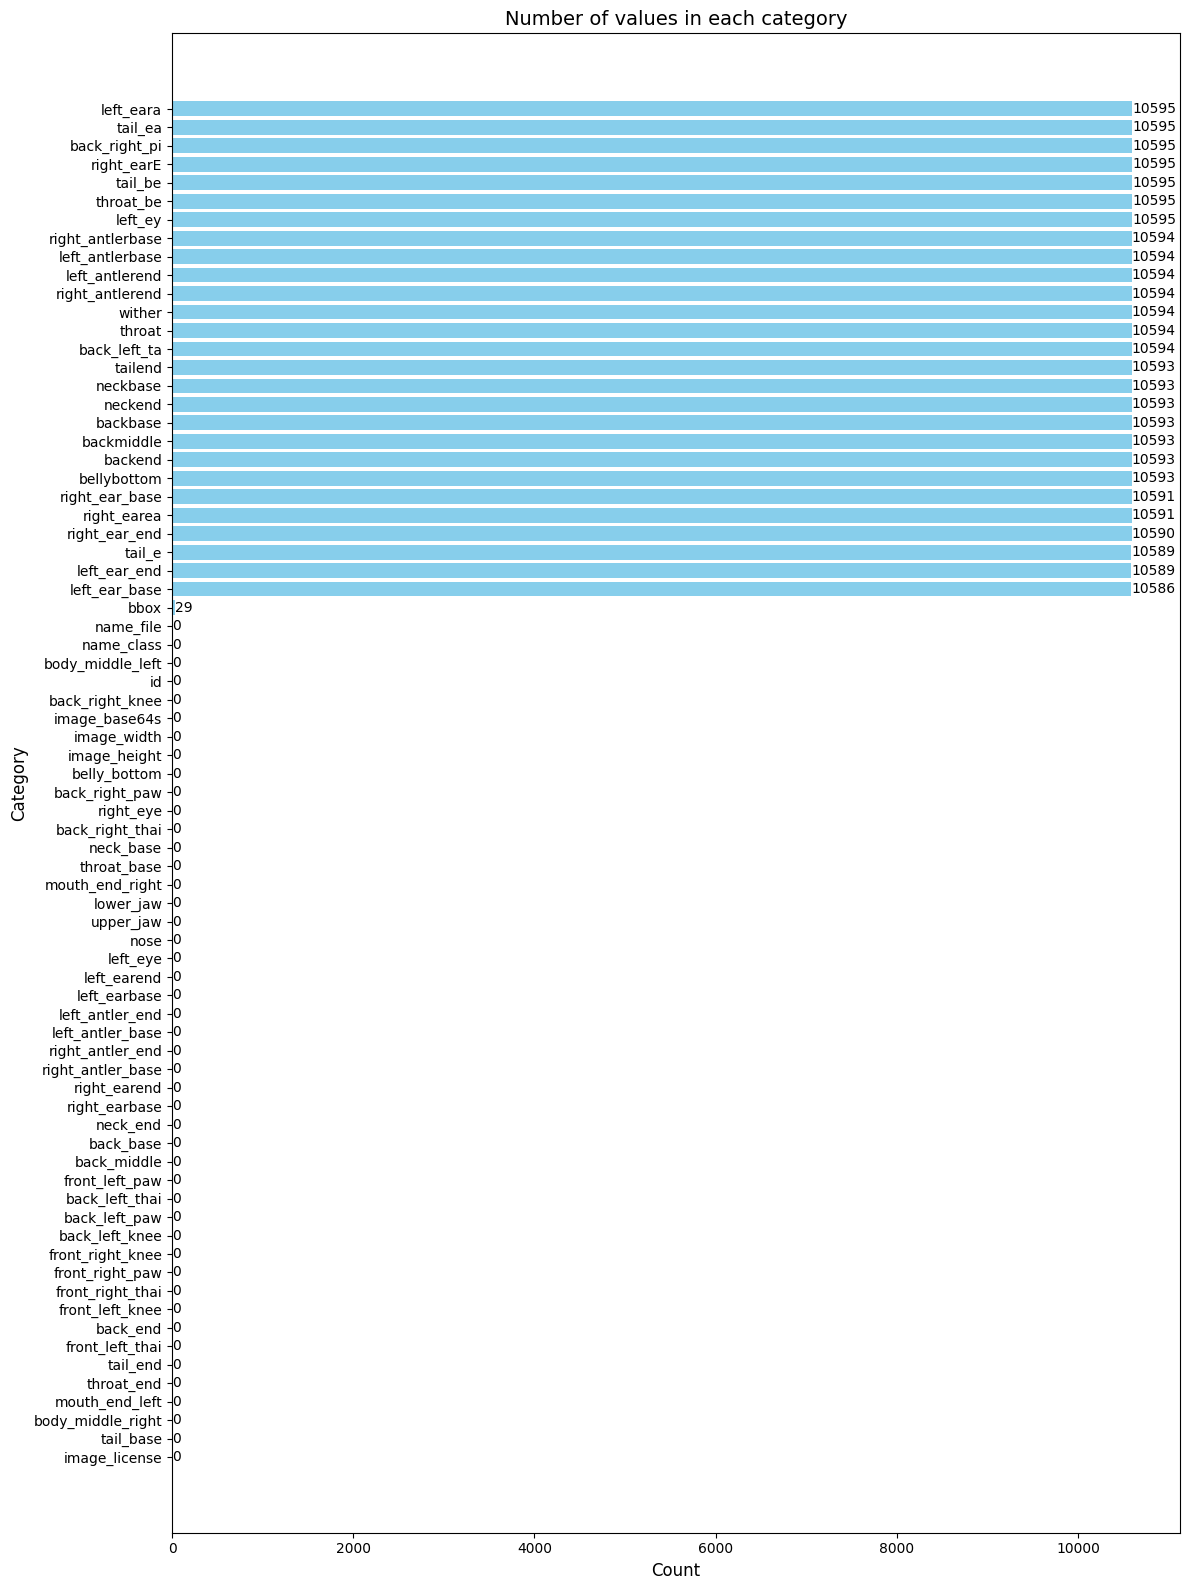

In [47]:
plot_graph(null_count_dict)

> We see two things here, in some cases we don't have a building box, we'll have to investigate those. Also, we can see that the original keypoints files didn't have consistent point descriptions. We'll have to fix that.

### **Viewing the amount of data per class**

In [48]:
class_name_df = df_animals_keypoints_all.select('name_class').unique()

In [49]:
class_names_struct = class_name_df.to_struct()
list_class_input = []
for name in class_names_struct:
    list_class_input.append(list(name.values())[0])

list_class = sorted(list_class_input)

In [50]:
print(f"Total number of annotated classes: {len(list_class)}")

Total number of annotated classes: 37


In [51]:
view_class_count = df_animals_keypoints_all.group_by("name_class").len().to_pandas()

In [52]:
view_class_count.sort_values(by=['len'])

,name_class,len
1,sample,2
8,rat,13
15,skunk,97
26,weasel,208
4,buffalo,257
16,siamese+cat,283
24,antelope,304
19,persian+cat,305
33,otter,305
18,raccoon,306


<Axes: xlabel='name_class'>

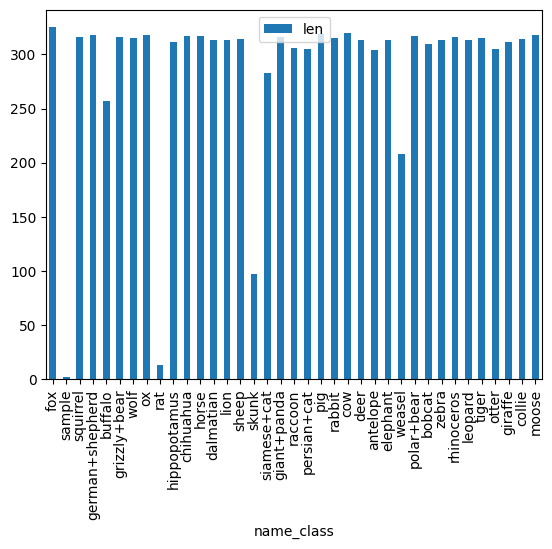

In [53]:
view_class_count.plot.bar(x='name_class', y='len', rot=90)

> You can also see that the dataset contains the sample class (2 pieces), which we don't need, and the rat and skunk classes are quite unbalanced in terms of the number of samples.

### **Viewing the error of bounding boxes**

In [54]:
df_bbox_null = df_animals_keypoints_all.filter(pl.col("bbox").is_null())

In [55]:
df_bbox_null.head(5)

id,right_eye,right_earbase,right_earend,right_antler_base,right_antler_end,left_antler_base,left_antler_end,left_earbase,left_earend,left_eye,nose,upper_jaw,lower_jaw,mouth_end_right,throat_base,neck_base,neck_end,back_base,back_middle,back_end,tail_base,body_middle_right,bbox,mouth_end_left,throat_end,tail_end,front_left_thai,front_left_knee,front_left_paw,front_right_thai,front_right_paw,front_right_knee,back_left_knee,back_left_paw,back_left_thai,back_right_thai,back_right_paw,back_right_knee,belly_bottom,body_middle_left,name_file,name_class,left_antlerbase,left_antlerend,right_antlerend,right_antlerbase,neckbase,neckend,backbase,backmiddle,backend,tailend,bellybottom,back_right_pi,tail_e,left_eara,right_earE,right_earea,left_ear_base,left_ear_end,right_ear_end,right_ear_base,tail_ea,wither,throat,left_ey,throat_be,tail_be,back_left_ta,image_base64s,image_width,image_height,image_license
u32,list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],str,str,list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],str,i64,i64,str
85,"[648.444444, 208.333333]","[640.0, 193.666667]","[587.555556, 159.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[721.777778, 184.777778]","[768.888889, 144.333333]","[706.666667, 203.888889]","[668.888889, 269.666667]","[673.333333, 290.555556]","[670.222222, 297.666667]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[273.333333, 338.111111]","[475.111111, 347.0]",null,"[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[596.888889, 440.333333]","[597.333333, 529.666667]","[604.0, 651.888889]","[563.111111, 422.111111]","[563.555556, 653.222222]","[556.444444, 527.888889]","[251.555556, 510.555556]","[251.555556, 663.888889]","[300.888889, 415.888889]","[352.0, 397.222222]","[343.111111, 651.0]","[302.222222, 516.777778]","[-1.0, -1.0]","[-1.0, -1.0]","""antelope_10225""","""sample""","[691.111111, 161.666667]","[705.333333, 52.777778]","[655.111111, 59.888889]","[662.222222, 167.0]","[624.888889, 255.888889]","[647.555556, 233.222222]","[611.111111, 248.333333]","[472.0, 262.111111]","[320.888889, 283.0]","[241.333333, 492.777778]","[452.0, 441.222222]",null,null,null,null,null,null,null,null,null,null,"[640.0, 384.333333]","[669.333333, 307.888889]",null,null,null,null,"""/9j/4AAQSkZJRgABAQAAAQABAAD//g…",1024,702,"""+-----------------------------…"
1780,"[863.159292, 405.044248]","[808.292035, 376.725664]","[741.035398, 347.522124]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[988.380531, 503.274336]","[963.60177, 528.053097]","[951.654867, 542.654867]","[918.469027, 524.070796]","[816.256637, 490.0]","[807.849558, 338.672566]","[715.814159, 309.469027]","[681.743363, 298.849558]","[460.504425, 345.309735]","[140.150442, 440.884956]","[104.309735, 468.761062]","[478.20354, 463.451327]",null,"[-1.0, -1.0]","[776.876106, 528.938053]","[135.725664, 606.814159]","[-1.0, -1.0]","[810.504425, 557.699115]","[-1.0, -1.0]","[634.840708, 516.106195]","[610.061947, 620.973451]","[745.017699, 608.141593]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[246.787611, 500.619469]","[421.566372, 689.557522]","[302.539823, 624.513274]","[465.371681, 599.734513]","[-1.0, -1.0]","""cow_10287""","""cow""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,

In [56]:
print(f"Number of error samples: {df_bbox_null.shape[0]}")

Number of error samples: 29


#### ***Show samples***

In [57]:
plot_samples_bbox_err = df_bbox_null.sample(n=8)

In [58]:
plot_samples_bbox_err

id,right_eye,right_earbase,right_earend,right_antler_base,right_antler_end,left_antler_base,left_antler_end,left_earbase,left_earend,left_eye,nose,upper_jaw,lower_jaw,mouth_end_right,throat_base,neck_base,neck_end,back_base,back_middle,back_end,tail_base,body_middle_right,bbox,mouth_end_left,throat_end,tail_end,front_left_thai,front_left_knee,front_left_paw,front_right_thai,front_right_paw,front_right_knee,back_left_knee,back_left_paw,back_left_thai,back_right_thai,back_right_paw,back_right_knee,belly_bottom,body_middle_left,name_file,name_class,left_antlerbase,left_antlerend,right_antlerend,right_antlerbase,neckbase,neckend,backbase,backmiddle,backend,tailend,bellybottom,back_right_pi,tail_e,left_eara,right_earE,right_earea,left_ear_base,left_ear_end,right_ear_end,right_ear_base,tail_ea,wither,throat,left_ey,throat_be,tail_be,back_left_ta,image_base64s,image_width,image_height,image_license
u32,list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],str,str,list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],str,i64,i64,str
8425,"[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[170.172414, 2.0]","[-1.0, -1.0]","[136.896552, 132.862069]","[75.689655, 207.517241]","[80.344828, 227.517241]","[97.413793, 232.172414]","[-1.0, -1.0]","[318.62069, 133.034483]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]",null,"[144.482759, 201.655172]","[386.37931, 129.758621]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","""rhinoceros_10041""","""rhinoceros""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""/9j/4AAQSkZJRgABAQAAAQABAAD/2w…",400,300,"""+-----------------------------…"
8106,"[718.468468, 15.936937]","[752.702703, 85.756757]","[796.396396, 114.135135]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[659.459459, 111.432432]","[629.72973, 148.369369]","[651.801802, 31.252252]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[615.315315, 122.243243]","[731.981982, 131.252252]","[744.594595, 168.63964]","[747.747748, 183.054054]","[750.900901, 456.027027]","[805.405405, 684.405405]","[821.621622, 723.144144]","[-1.0, -1.0]",null,"[-1.0, -1.0]","[613.963964, 165.936937]","[-1.0, -1.0]","[633.333333, 279.900901]","[582.882883, 300.621622]","[507.657658, 312.333333]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[596.846847, 733.054054]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[582.432432, 498.81982]","[668.018018, 472.243243]","""rat_10017""","""rat""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""/9j/4AAQSkZJRgABAQAAAQABAAD/2w…",1024,768,"""+-----------------------------…"
4076,"[477.586207, 414.034483]","[457.241379, 360.241379]","[444.482759, 337.827586]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[-1.0, -1.0]","[531.034483, 366.103448]","[552.068966, 340.586207]","[509.310345, 416.103448]","[486.206897, 466.793103]","[480.689655, 472.655172]","[-1.0, -1.0]","[468.275862, 449.551724]","[-1.0, -1.0]","[479.310345, 323.0]","[451.724138, 283.0]","[421.0344

In [59]:
images_bbox_err = plot_samples_bbox_err.select(['image_base64s'])

In [60]:
list_bbox_err = images_bbox_err.to_pandas().to_numpy().tolist()
list_bbox_err

[['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAEsAZADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwC9J4Ut5C7C2F7btjypr67kcqAuQqASEAYAAJQgZORgYObfT6fD5t2dPfVUj2wJ9ikFv5cQLuUkKphjlskhRwoORxu3tPSfxlq/9majdSR6baRCSWC2YKjMCBGrvgM7EZJwAo2gbQTTR4i0nw148vGhZ5Y5ZPIniKD/AFaoh